In [1]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from numpy import clip
from torch.autograd import Variable
import torch
from torch import Tensor
from torch.optim import SGD
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact
from scipy import special
w = widgets.IntText()
%matplotlib inline
%run utils.py

In [2]:
M, N = (20,70) 

In [3]:
def unif_path_weights(source, target):
    sx, sy = source
    tx, ty = target
    x_d, y_d = abs(tx-sx), abs(ty-sy)
    
    x, y = np.meshgrid(range(x_d+1), range(y_d+1))
    
    paths1 = special.binom(x+y,x)
    paths2 = special.binom(x_d+y_d-x-y, x_d-x)
    total_paths = special.binom(x_d+y_d,x_d)
    
    small_grid = (paths1 * paths2 / total_paths).T
    
    if (tx-sx)*(ty-sy) < 0:
        small_grid = small_grid[::-1, :]
    
    full_grid = np.zeros((M,N))
    full_grid[min(sx, tx):max(sx,tx)+1, min(sy, ty):max(sy,ty)+1] = small_grid
    
    return full_grid

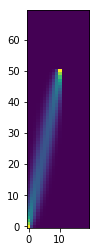

In [4]:
plt.imshow(unif_path_weights((10,50), (0,0)).T, origin='lower')

In [5]:
weights = Variable((15 * torch.ones((M,N))).float(), requires_grad=True)

In [6]:
@interact(x=w)
def plot(x):
    plt.figure(figsize=(10,10))
    plt.imshow(torch.nn.functional.softplus(weights).data.numpy().T, 
               clim=(0,80), cmap='bwr', origin='lower')
    plt.show()
    

interactive(children=(IntText(value=0, description='x'), Output()), _dom_classes=('widget-interact',))

In [7]:
def predict(sx, sy, tx, ty):
    sx, sy, tx, ty = sx//2, sy//2, tx//2, ty//2
    
    source = (int(sx), int(sy))
    target = (int(tx), int(ty))
    path = unif_path_weights(source, target)
    pred = (Variable(Tensor(path)) 
            * torch.nn.functional.softplus(weights)).sum()
    return pred
    
def predict_num(sx, sy, tx, ty):
    return predict(sx, sy, tx, ty).data[0]

In [8]:
optimizer = SGD([weights], lr = 1e-4)
num_epochs = 5

df = pd.read_csv('data/split/JC_week1_hour8_40x140.csv')
losses = []
pbar = tqdm(total=num_epochs*len(df))
for epoch in range(num_epochs):
    for _, duration, sx, sy, tx, ty in df.sample(frac=1).itertuples():
        if pbar.n % 1000 == 0:
            w.value += 1
        pbar.update(1)
        pred = predict(sx, sy, tx, ty)
        loss = (pred - duration) ** 2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])

HBox(children=(IntProgress(value=0, max=390810), HTML(value='')))

390810/|/100%|| 390810/390810 [05:10<00:00, 1552.21it/s]

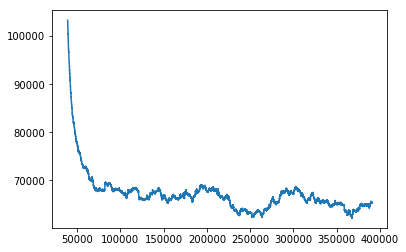

In [9]:
plt.plot(pd.Series(losses).rolling(len(losses)//10).mean())

In [49]:
weights

Variable containing:
  18.2937   15.2162   15.9050  ...    15.0000   15.0000   15.0000
  16.5694   15.2121   15.2728  ...    15.0000   15.0000   15.0000
  15.5406   14.5234   14.7567  ...    15.0000   15.0000   15.0000
             ...                ⋱                ...             
  15.0000   15.0000   15.0000  ...    14.1062   91.7242  131.6433
  15.0000   15.0000   15.0000  ...    10.0105  116.4045   56.7057
  15.0000   15.0000   15.0000  ...   139.4594  143.5306  145.2057
[torch.FloatTensor of size 40x140]

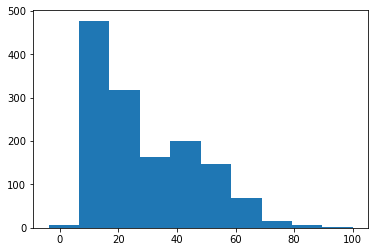

In [10]:
plt.hist((weights.data.numpy()[~np.isnan(weights.data.numpy())]));

In [45]:
test_df = pd.read_csv('data/split_test/JC_week1_hour8_test_40x140.csv')

In [13]:
%run test.py

In [14]:
errs = test(predict_num, 'results/unif_tues8am_Fri2208')

HBox(children=(IntProgress(value=0, max=9697), HTML(value='')))

In [46]:
test_df.head()

,duration,sx,sy,tx,ty
0,480.0,25.0,37.0,34.0,28.0
1,780.0,9.0,26.0,22.0,45.0
2,720.0,22.0,102.0,7.0,93.0
3,480.0,15.0,39.0,23.0,44.0
4,1178.0,10.0,23.0,23.0,59.0


In [47]:
test_df['d'] = (test_df.sx - test_df.tx)**2 + (test_df.sy - test_df.ty)**2

In [48]:
import statsmodels.formula.api as smf

In [52]:
print(smf.ols('duration ~ d', data=test_df).fit().summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.353      
Dependent Variable: duration         AIC:                138161.7210
Date:               2017-12-08 22:32 BIC:                138176.0802
No. Observations:   9697             Log-Likelihood:     -69079.    
Df Model:           1                F-statistic:        5289.      
Df Residuals:       9695             Prob (F-statistic): 0.00       
R-squared:          0.353            Scale:              90201.     
---------------------------------------------------------------------
              Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
---------------------------------------------------------------------
Intercept    506.0068    3.5703  141.7283  0.0000  499.0083  513.0052
d              0.2523    0.0035   72.7236  0.0000    0.2455    0.2591
--------------------------------------------------------------------
Omnibus:              4072.711      Durbin-Watso